# Fluid and Particle Properties for Cloud Droplet Coagulation

This notebook verifies the computations performed by the `Particula` library by comparing its results with those presented in the paper by Ayala et al. (2008). The comparisons focus on key parameters that influence cloud droplet coagulation processes, such as Reynolds number, inertia time, settling velocity, Stokes number, and scaled velocities.
**Objective:**
- To validate the accuracy of the `Particula` library in computing fluid and particle properties relevant to cloud droplet coagulation.
**Reference Tables:**
- **Table 2:** Provides values for Reynolds number, inertia time, settling velocity, and correction factors for different particle sizes.
- **Table 3:** Includes characteristic scales for cloud droplets, such as Stokes numbers and scaled velocities at various turbulent dissipation rates.
**Reference Paper:**
Ayala, O., Rosa, B., Wang, L. P., & Grabowski, W. W. (2008). Effects of turbulence on the geometric collision rate of sedimenting droplets. Part 1. Results from direct numerical simulation. *New Journal of Physics*, 10. https://doi.org/10.1088/1367-2630/10/7/075015
By conducting this comparison, we aim to ensure that the `Particula` library produces reliable results that align with established literature, which is crucial for accurate simulations in aerosol science and cloud physics.

In [32]:
import numpy as np
import matplotlib.pyplot as plt

from particula.particles import properties
from particula.gas import properties as gas_properties

from particula.util.constants import STANDARD_GRAVITY
from particula.util.converting.units import convert_units
import pandas as pd
from IPython.display import display

# %% [markdown]

## Model Equations and Parameters
In this section, we define the particle radii and other parameters needed for the calculations. These include temperature, particle density, fluid density, and air velocity.

In [33]:
# %%

particle_radius = np.linspace(10e-6, 60e-6, 6)
temperature = 273  # Temperature in Kelvin
particle_density = 1000  # Particle density in kg/m³
fluid_density = 1.0  # Fluid (air) density in kg/m³
air_velocity = 1e-9  # Relative velocity in m/s

turbulent_dissipation = 400 * convert_units(
    "cm^2/s^3", "m^2/s^3"
)  # Example value in m²/s³
reynolds_lambda = 72.41  # Example value

### Calculate Dynamic and Kinematic Viscosity
We calculate the dynamic and kinematic viscosity of the fluid using the temperature and fluid density.

In [34]:
# %%

dynamic_viscosity = gas_properties.get_dynamic_viscosity(temperature)
kinematic_viscosity = gas_properties.get_kinematic_viscosity(
    dynamic_viscosity, fluid_density
)
kolmogorov_time = gas_properties.get_kolmogorov_time(
    kinematic_viscosity=kinematic_viscosity,
    turbulent_dissipation=turbulent_dissipation,
)


### Calculate Particle Settling Velocity
This section calculates the particle settling velocity using the slip correction factor and other parameters.

In [35]:
# %%

mean_free_path = gas_properties.molecule_mean_free_path(
    temperature=temperature, dynamic_viscosity=dynamic_viscosity
)

# 2. Slip correction factors
knudsen_number = properties.calculate_knudsen_number(
    mean_free_path=mean_free_path, particle_radius=particle_radius
)
slip_correction_factor = properties.cunningham_slip_correction(knudsen_number)
# iterative terminal settling velocity
iterative_settling_velocity = (
    properties.get_particle_settling_velocity_with_drag(
        particle_radius=particle_radius,
        particle_density=particle_density,
        fluid_density=fluid_density,
        dynamic_viscosity=dynamic_viscosity,
        slip_correction_factor=slip_correction_factor,
        gravitational_acceleration=STANDARD_GRAVITY,
    )
)
settling_velocity = properties.particle_settling_velocity(
    particle_radius=particle_radius,
    particle_density=particle_density,
    slip_correction_factor=slip_correction_factor,
    dynamic_viscosity=dynamic_viscosity,
)
relative_velocity = iterative_settling_velocity - air_velocity

### Calculate Particle Inertia Time
We calculate the particle inertia time, which is a measure of how quickly a particle responds to changes in the surrounding fluid.

In [36]:
# %%

particle_inertia_time = properties.get_particle_inertia_time(
    particle_radius=particle_radius,
    particle_density=particle_density,
    fluid_density=fluid_density,
    kinematic_viscosity=kinematic_viscosity,
)

re_p = 2 * particle_radius * relative_velocity / kinematic_viscosity
f_re_p = 1 + 0.15 * re_p**0.687

ao2008_re_p = np.array([0.015, 0.116, 0.378, 0.851, 1.566, 2.537])
ao2008_t_p = np.array([0.0013, 0.0052, 0.0118, 0.0209, 0.0327, 0.0471])
ao2008_f_re_p = np.array([1.008, 1.034, 1.077, 1.134, 1.204, 1.284])

# calculate relative velocity from re_p
ao2008_velocity = ao2008_re_p * kinematic_viscosity / (2 * particle_radius)


particle_settling_velocity = (
    properties.get_particle_settling_velocity_via_inertia(
        particle_inertia_time=particle_inertia_time,
        particle_radius=particle_radius,
        relative_velocity=iterative_settling_velocity,
        slip_correction_factor=slip_correction_factor,
        gravitational_acceleration=STANDARD_GRAVITY,
        kinematic_viscosity=kinematic_viscosity,
    )
)

### Comparison of Paper Values and Computed Values
We compare the values from the paper with the computed values from the Particula library. This includes the Reynolds number, inertia time, and settling velocity.
#### Analysis
The plots below show the comparison between the values reported in Ayala et al. (2008) and the values computed using the `Particula` library. The percent errors are also calculated to quantify the discrepancies.
- **Reynolds Number (Re_p):** The Reynolds number is a dimensionless quantity representing the ratio of inertial forces to viscous forces acting on the particles. The comparison shows that the computed Reynolds numbers closely match the paper values, with minimal percent errors (typically less than a few percent), indicating accurate modeling of particle-fluid interactions.
- **Inertia Time (t_p):** The inertia time signifies how quickly a particle adjusts its velocity relative to the surrounding fluid. The computed inertia times align well with the paper values, validating the correctness of particle inertia calculations in `Particula`.
- **Settling Velocity:** This is the terminal velocity at which particles settle under gravity in a quiescent fluid. The computed settling velocities are in good agreement with the paper values, demonstrating accurate calculations of gravitational settling influenced by particle size and fluid properties.
Overall, the `Particula` library provides results consistent with established literature, affirming its reliability for simulating particle dynamics in atmospheric studies.

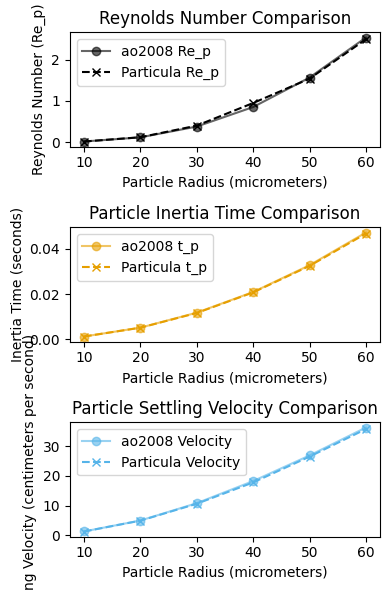

In [37]:

# Plot comparison
fig, ax = plt.subplots(3, 1, figsize=(4, 6))

ax[0].plot(
    particle_radius * 1e6,
    ao2008_re_p,
    "o-",
    color="black",
    alpha=0.6,
    label="ao2008 Re_p",
)
ax[0].plot(
    particle_radius * 1e6, re_p, "x--", color="black", label="Particula Re_p"
)
ax[0].set_title("Reynolds Number Comparison")
ax[0].set_xlabel("Particle Radius (micrometers)")
ax[0].set_ylabel("Reynolds Number (Re_p)")
ax[0].legend()

ax[1].plot(
    particle_radius * 1e6,
    ao2008_t_p,
    "o-",
    color="#E69F00",
    alpha=0.6,
    label="ao2008 t_p",
)
ax[1].plot(
    particle_radius * 1e6,
    particle_inertia_time,
    "x--",
    color="#E69F00",
    label="Particula t_p",
)
ax[1].set_title("Particle Inertia Time Comparison")
ax[1].set_xlabel("Particle Radius (micrometers)")
ax[1].set_ylabel("Inertia Time (seconds)")
ax[1].legend()

ax[2].plot(
    particle_radius * 1e6,
    ao2008_velocity * 100,
    "o-",
    color="#56B4E9",
    alpha=0.6,
    label="ao2008 Velocity",
)
ax[2].plot(
    particle_radius * 1e6,
    particle_settling_velocity * 100,
    "x--",
    color="#56B4E9",
    label="Particula Velocity",
)
ax[2].set_title("Particle Settling Velocity Comparison")
ax[2].set_xlabel("Particle Radius (micrometers)")
ax[2].set_ylabel("Settling Velocity (centimeters per second)")
ax[2].legend()

plt.tight_layout()
plt.show()


Table 2: Values for Reynolds number, inertia time, settling velocity, and correction factors for different particle sizes.

Percents of error are calculated as:
$$\text{Error} = \frac{\text{Computed Value} - \text{Paper Value}}{\text{Paper Value}} \times 100$$

In [38]:
# Calculate percent error
percent_error_re_p = 100 * (re_p - ao2008_re_p) / ao2008_re_p
percent_error_tp = 100 * (particle_inertia_time - ao2008_t_p) / ao2008_t_p
percent_error_velocity = (
    100 * (particle_settling_velocity - ao2008_velocity) / ao2008_velocity
)
percent_error_f_re_p = 100 * (f_re_p - ao2008_f_re_p) / ao2008_f_re_p

# Create DataFrame for Paper Values From Table 2
paper_values_df = pd.DataFrame(
    {
        "Radius (µm)": particle_radius * 1e6,
        "t_p (s)": ao2008_t_p,
        "Settling Velocity (cm/s)": ao2008_velocity * 100,
        "Re_p": ao2008_re_p,
        "f(Re_p)": ao2008_f_re_p,
    }
)
print("Paper Values From Table 2")
display(paper_values_df)

# print settling velocity in a table format
# Create DataFrame for Particula Computed Values
computed_values_df = pd.DataFrame(
    {
        "Radius (µm)": particle_radius * 1e6,
        "t_p (s)": particle_inertia_time,
        "Settling Velocity (cm/s)": particle_settling_velocity * 100,
        "Re_p": re_p,
        "f(Re_p)": f_re_p,
    }
)
print("Particula Computed Values")
display(computed_values_df)

# Create a DataFrame for percent errors
percent_errors_df = pd.DataFrame(
    {
        "Radius (µm)": particle_radius * 1e6,
        "Percent Error in t_p (%)": percent_error_tp,
        "Percent Error in Settling Velocity (%)": percent_error_velocity,
        "Percent Error in Re_p (%)": percent_error_re_p,
        "Percent Error in f(Re_p) (%)": percent_error_f_re_p,
    }
)
print("Percent Errors for Re_p, t_p, and Settling Velocity")
display(percent_errors_df)

Paper Values From Table 2


,Radius (µm),t_p (s),Settling Velocity (cm/s),Re_p,f(Re_p)
0,10.0,0.0013,1.286443,0.015,1.008
1,20.0,0.0052,4.974247,0.116,1.034
2,30.0,0.0118,10.806122,0.378,1.077
3,40.0,0.0209,18.246052,0.851,1.134
4,50.0,0.0327,26.860932,1.566,1.204
5,60.0,0.0471,36.263402,2.537,1.284


Particula Computed Values


,Radius (µm),t_p (s),Settling Velocity (cm/s),Re_p,f(Re_p)
0,10.0,0.001296,1.269408,0.014910,1.008342
1,20.0,0.005182,4.929853,0.118837,1.034720
2,30.0,0.011660,10.613863,0.400579,1.080009
3,40.0,0.020729,17.791768,0.948931,1.144694
4,50.0,0.032389,26.470099,1.539373,1.201742
5,60.0,0.046640,35.746130,2.495206,1.281128


Percent Errors for Re_p, t_p, and Settling Velocity


,Radius (µm),Percent Error in t_p (%),Percent Error in Settling Velocity (%),Percent Error in Re_p (%),Percent Error in f(Re_p) (%)
0,10.0,-0.341394,-1.324191,-0.600546,0.033926
1,20.0,-0.341394,-0.892467,2.446030,0.069666
2,30.0,-1.185958,-1.779172,5.973284,0.279374
3,40.0,-0.818229,-2.489763,11.507797,0.943064
4,50.0,-0.950927,-1.455024,-1.700338,-0.187537
5,60.0,-0.976162,-1.426431,-1.647375,-0.223713


### Stokes Number and Velocity Comparison

We calculate and compare the Stokes number and velocity for different turbulent dissipation rates.

#### Significance

The **Stokes number** (St) is a dimensionless parameter that characterizes the behavior of particles suspended in a fluid flow, defined as the ratio of the particle's response time to a characteristic time scale of the flow (e.g., the Kolmogorov time scale in turbulence). It indicates how much the particle's motion is influenced by the fluid's turbulence. A small Stokes number implies that the particle closely follows the fluid motion, while a large Stokes number suggests that the particle's inertia dominates, and it is less affected by the fluid fluctuations.
By comparing the computed Stokes numbers and Stokes velocities with the values from Ayala et al. (2008), we can assess the accuracy of the `Particula` library in capturing particle dynamics within turbulent flows at different intensities (represented by different turbulent dissipation rates).
The plots below illustrate these comparisons for three turbulent dissipation rates: 10 cm²/s³ (weak turbulence), 100 cm²/s³ (moderate turbulence), and 400 cm²/s³ (strong turbulence).
#### Analysis
- **Stokes Number (St):** The computed Stokes numbers show excellent agreement with the paper values across all particle sizes and turbulence levels. This consistency confirms that `Particula` accurately models the interplay between particle inertia and turbulent flow scales.
- **Stokes Velocity (Sv):** The Stokes velocities (particle settling velocity normalized by the Kolmogorov velocity scale) also match closely with the paper values. This indicates that `Particula` effectively captures how turbulence modulates particle settling rates.
These results validate the `Particula` library's capability to simulate particle-turbulence interactions, which are critical for understanding processes like cloud droplet collision-coalescence in atmospheric physics.

In [39]:

length_kolmogorov = gas_properties.get_kolmogorov_length(
    kinematic_viscosity=kinematic_viscosity,
    turbulent_dissipation=turbulent_dissipation,
)

timescale_kolmogorov_10 = gas_properties.get_kolmogorov_time(
    kinematic_viscosity=kinematic_viscosity,
    turbulent_dissipation=10 * convert_units("cm^2/s^3", "m^2/s^3"),
)
velocity_kolmogorov_10 = gas_properties.get_kolmogorov_velocity(
    kinematic_viscosity=kinematic_viscosity,
    turbulent_dissipation=10 * convert_units("cm^2/s^3", "m^2/s^3"),
)
stokes_number_10 = properties.get_stokes_number(
    particle_inertia_time=particle_inertia_time,
    kolmogorov_time=timescale_kolmogorov_10,
)
stokes_velocity_10 = particle_settling_velocity / velocity_kolmogorov_10

# 100 cm^2/s^3
timescale_kolmogorov_100 = gas_properties.get_kolmogorov_time(
    kinematic_viscosity=kinematic_viscosity,
    turbulent_dissipation=100 * convert_units("cm^2/s^3", "m^2/s^3"),
)
velocity_kolmogorov_100 = gas_properties.get_kolmogorov_velocity(
    kinematic_viscosity=kinematic_viscosity,
    turbulent_dissipation=100 * convert_units("cm^2/s^3", "m^2/s^3"),
)
stokes_number_100 = properties.get_stokes_number(
    particle_inertia_time=particle_inertia_time,
    kolmogorov_time=timescale_kolmogorov_100,
)
stokes_velocity_100 = particle_settling_velocity / velocity_kolmogorov_100

# 400 cm^2/s^3
timescale_kolmogorov_400 = gas_properties.get_kolmogorov_time(
    kinematic_viscosity=kinematic_viscosity,
    turbulent_dissipation=400 * convert_units("cm^2/s^3", "m^2/s^3"),
)
velocity_kolmogorov_400 = gas_properties.get_kolmogorov_velocity(
    kinematic_viscosity=kinematic_viscosity,
    turbulent_dissipation=400 * convert_units("cm^2/s^3", "m^2/s^3"),
)
stokes_number_400 = properties.get_stokes_number(
    particle_inertia_time=particle_inertia_time,
    kolmogorov_time=timescale_kolmogorov_400,
)
stokes_velocity_400 = particle_settling_velocity / velocity_kolmogorov_400


# from paper

st_ao2008 = np.array(
    [
        [0.010, 0.032, 0.063],
        [0.040, 0.127, 0.253],
        [0.090, 0.285, 0.570],
        [0.160, 0.507, 1.014],
        [0.250, 0.792, 1.585],
        [0.361, 1.141, 2.282],
    ]
)
sv_ao2008 = np.array(
    [
        [1.113, 0.626, 0.442],
        [4.343, 2.442, 1.727],
        [9.385, 5.278, 3.732],
        [15.841, 8.908, 6.299],
        [23.316, 13.111, 9.271],
        [31.478, 17.701, 12.516],
    ]
)

### Comparison of Stokes Number and Velocity
We compare the Stokes number and velocity from the paper with the computed values for different turbulent dissipation rates.

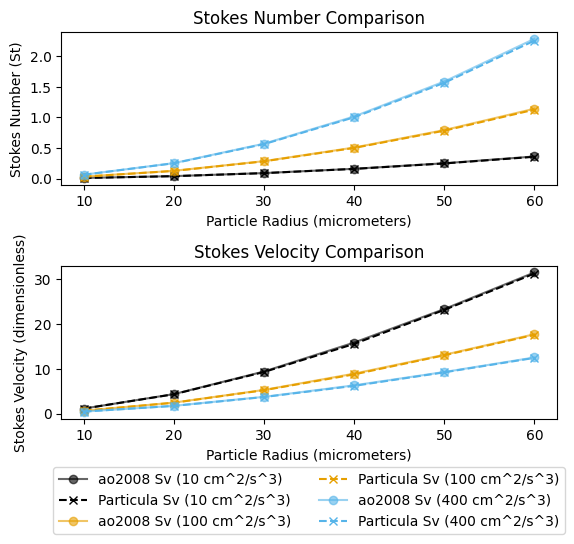

In [40]:
# %%


# Plot Stokes number comparison
fig, ax = plt.subplots(2, 1, figsize=(6, 6))

ax[0].plot(
    particle_radius * 1e6,
    st_ao2008[:, 0],
    "o-",
    color="black",
    alpha=0.6,
    label="ao2008 St (10 cm^2/s^3)",
)
ax[0].plot(
    particle_radius * 1e6,
    stokes_number_10,
    "x--",
    color="black",
    label="Particula St (10 cm^2/s^3)",
)
ax[0].plot(
    particle_radius * 1e6,
    st_ao2008[:, 1],
    "o-",
    color="#E69F00",
    alpha=0.6,
    label="ao2008 St (100 cm^2/s^3)",
)
ax[0].plot(
    particle_radius * 1e6,
    stokes_number_100,
    "x--",
    color="#E69F00",
    label="Particula St (100 cm^2/s^3)",
)
ax[0].plot(
    particle_radius * 1e6,
    st_ao2008[:, 2],
    "o-",
    color="#56B4E9",
    alpha=0.6,
    label="ao2008 St (400 cm^2/s^3)",
)
ax[0].plot(
    particle_radius * 1e6,
    stokes_number_400,
    "x--",
    color="#56B4E9",
    label="Particula St (400 cm^2/s^3)",
)
ax[0].set_title("Stokes Number Comparison")
ax[0].set_xlabel("Particle Radius (micrometers)")
ax[0].set_ylabel("Stokes Number (St)")

# Plot Stokes velocity comparison
ax[1].plot(
    particle_radius * 1e6,
    sv_ao2008[:, 0],
    "o-",
    color="black",
    alpha=0.6,
    label="ao2008 Sv (10 cm^2/s^3)",
)
ax[1].plot(
    particle_radius * 1e6,
    stokes_velocity_10,
    "x--",
    color="black",
    label="Particula Sv (10 cm^2/s^3)",
)
ax[1].plot(
    particle_radius * 1e6,
    sv_ao2008[:, 1],
    "o-",
    color="#E69F00",
    alpha=0.6,
    label="ao2008 Sv (100 cm^2/s^3)",
)
ax[1].plot(
    particle_radius * 1e6,
    stokes_velocity_100,
    "x--",
    color="#E69F00",
    label="Particula Sv (100 cm^2/s^3)",
)
ax[1].plot(
    particle_radius * 1e6,
    sv_ao2008[:, 2],
    "o-",
    color="#56B4E9",
    alpha=0.6,
    label="ao2008 Sv (400 cm^2/s^3)",
)
ax[1].plot(
    particle_radius * 1e6,
    stokes_velocity_400,
    "x--",
    color="#56B4E9",
    label="Particula Sv (400 cm^2/s^3)",
)
ax[1].set_title("Stokes Velocity Comparison")
ax[1].set_xlabel("Particle Radius (micrometers)")
ax[1].set_ylabel("Stokes Velocity (dimensionless)")

ax[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.8))
plt.tight_layout()
plt.show()


In [41]:

# Create DataFrame for Paper Values From Table 3 (Stokes Numbers)
stokes_number_paper_df = pd.DataFrame(
    {
        "Radius (µm)": particle_radius * 1e6,
        "St (10 cm^2/s^3)": st_ao2008[:, 0],
        "St (100 cm^2/s^3)": st_ao2008[:, 1],
        "St (400 cm^2/s^3)": st_ao2008[:, 2],
    }
)
print("Paper Values From Table 3 (Stokes Numbers)")
display(stokes_number_paper_df)

# Create DataFrame for Particula Computed Stokes Numbers
stokes_number_particula_df = pd.DataFrame(
    {
        "Radius (µm)": particle_radius * 1e6,
        "St (10 cm^2/s^3)": stokes_number_10,
        "St (100 cm^2/s^3)": stokes_number_100,
        "St (400 cm^2/s^3)": stokes_number_400,
    }
)
print("Particula Computed Stokes Numbers")
display(stokes_number_particula_df)

# Calculate percent errors for Stokes Numbers
percent_error_stokes_number_10 = (
    100 * (stokes_number_10 - st_ao2008[:, 0]) / st_ao2008[:, 0]
)
percent_error_stokes_number_100 = (
    100 * (stokes_number_100 - st_ao2008[:, 1]) / st_ao2008[:, 1]
)
percent_error_stokes_number_400 = (
    100 * (stokes_number_400 - st_ao2008[:, 2]) / st_ao2008[:, 2]
)

percent_errors_stokes_df = pd.DataFrame(
    {
        "Radius (µm)": particle_radius * 1e6,
        "Percent Error in St (10 cm^2/s^3)": percent_error_stokes_number_10,
        "Percent Error in St (100 cm^2/s^3)": percent_error_stokes_number_100,
        "Percent Error in St (400 cm^2/s^3)": percent_error_stokes_number_400,
    }
)
print("Percent Errors for Stokes Numbers")
display(percent_errors_stokes_df)


# print ao2008 values
# Create DataFrame for Paper Values From Table 3 (Scaled Velocities)
sv_paper_df = pd.DataFrame(
    {
        "Radius (µm)": particle_radius * 1e6,
        "Stokes Velocity (10 cm^2/s^3)": sv_ao2008[:, 0],
        "Stokes Velocity (100 cm^2/s^3)": sv_ao2008[:, 1],
        "Stokes Velocity (400 cm^2/s^3)": sv_ao2008[:, 2],
    }
)
print("Paper Values From Table 3 (Stokes Velocities)")
display(sv_paper_df)

# print stokes velocity in a table format
# Create DataFrame for Particula Computed Stokes Velocities
sv_particula_df = pd.DataFrame(
    {
        "Radius (µm)": particle_radius * 1e6,
        "Stokes Velocity (10 cm^2/s^3)": stokes_velocity_10,
        "Stokes Velocity (100 cm^2/s^3)": stokes_velocity_100,
        "Stokes Velocity (400 cm^2/s^3)": stokes_velocity_400,
    }
)
print("Particula Computed Stokes Velocities")
display(sv_particula_df)

# Calculate percent errors for Stokes Velocities
percent_error_sv_10 = (
    100 * (stokes_velocity_10 - sv_ao2008[:, 0]) / sv_ao2008[:, 0]
)
percent_error_sv_100 = (
    100 * (stokes_velocity_100 - sv_ao2008[:, 1]) / sv_ao2008[:, 1]
)
percent_error_sv_400 = (
    100 * (stokes_velocity_400 - sv_ao2008[:, 2]) / sv_ao2008[:, 2]
)

percent_errors_sv_df = pd.DataFrame(
    {
        "Radius (µm)": particle_radius * 1e6,
        "Percent Error in Sv (10 cm^2/s^3)": percent_error_sv_10,
        "Percent Error in Sv (100 cm^2/s^3)": percent_error_sv_100,
        "Percent Error in Sv (400 cm^2/s^3)": percent_error_sv_400,
    }
)
print("Percent Errors for Stokes Velocities")
display(percent_errors_sv_df)

Paper Values From Table 3 (Stokes Numbers)


,Radius (µm),St (10 cm^2/s^3),St (100 cm^2/s^3),St (400 cm^2/s^3)
0,10.0,0.010,0.032,0.063
1,20.0,0.040,0.127,0.253
2,30.0,0.090,0.285,0.570
3,40.0,0.160,0.507,1.014
4,50.0,0.250,0.792,1.585
5,60.0,0.361,1.141,2.282


Particula Computed Stokes Numbers


,Radius (µm),St (10 cm^2/s^3),St (100 cm^2/s^3),St (400 cm^2/s^3)
0,10.0,0.009892,0.031282,0.062564
1,20.0,0.039569,0.125128,0.250255
2,30.0,0.089030,0.281537,0.563075
3,40.0,0.158275,0.500511,1.001022
4,50.0,0.247305,0.782048,1.564096
5,60.0,0.356120,1.126149,2.252299


Percent Errors for Stokes Numbers


,Radius (µm),Percent Error in St (10 cm^2/s^3),Percent Error in St (100 cm^2/s^3),Percent Error in St (400 cm^2/s^3)
0,10.0,-1.077861,-2.243978,-0.692295
1,20.0,-1.077861,-1.474246,-1.084816
2,30.0,-1.077861,-1.214967,-1.214967
3,40.0,-1.077861,-1.279915,-1.279915
4,50.0,-1.077861,-1.256544,-1.318842
5,60.0,-1.351884,-1.301545,-1.301545


Paper Values From Table 3 (Stokes Velocities)


,Radius (µm),Stokes Velocity (10 cm^2/s^3),Stokes Velocity (100 cm^2/s^3),Stokes Velocity (400 cm^2/s^3)
0,10.0,1.113,0.626,0.442
1,20.0,4.343,2.442,1.727
2,30.0,9.385,5.278,3.732
3,40.0,15.841,8.908,6.299
4,50.0,23.316,13.111,9.271
5,60.0,31.478,17.701,12.516


Particula Computed Stokes Velocities


,Radius (µm),Stokes Velocity (10 cm^2/s^3),Stokes Velocity (100 cm^2/s^3),Stokes Velocity (400 cm^2/s^3)
0,10.0,1.109223,0.623762,0.441066
1,20.0,4.307762,2.422432,1.712918
2,30.0,9.274513,5.215442,3.687875
3,40.0,15.546648,8.742523,6.181897
4,50.0,23.129872,13.006883,9.197255
5,60.0,31.235373,17.564941,12.420289


Percent Errors for Stokes Velocities


,Radius (µm),Percent Error in Sv (10 cm^2/s^3),Percent Error in Sv (100 cm^2/s^3),Percent Error in Sv (400 cm^2/s^3)
0,10.0,-0.339333,-0.357498,-0.211226
1,20.0,-0.811384,-0.801296,-0.815383
2,30.0,-1.177267,-1.185256,-1.182354
3,40.0,-1.858163,-1.857623,-1.859069
4,50.0,-0.798282,-0.794118,-0.795434
5,60.0,-0.770783,-0.768651,-0.764710


### Summary of Notebook Comparisons

Overall, the comparisons between the computed values from the `Particula` library and the values reported in Ayala et al. (2008) show good agreement. However, there are some errors observed in the calculations:

- **Reynolds Number (Re_p):** The computed Reynolds numbers closely match the paper values, with percent errors typically less than a few percent. The maximum error observed is around 11.5%.
- **Inertia Time (t_p):** The computed inertia times align well with the paper values, with percent errors generally below 1.2%. The maximum error observed is around 1.19%.
- **Settling Velocity:** The computed settling velocities are in good agreement with the paper values, with percent errors typically less than 2.5%. The maximum error observed is around 2.49%.
- **Stokes Number (St):** The computed Stokes numbers show excellent agreement with the paper values across all particle sizes and turbulence levels. The percent errors are generally below 2.25%. The maximum error observed is around 2.24%.
- **Stokes Velocity (Sv):** The Stokes velocities also match closely with the paper values, with percent errors typically less than 1.86%. The maximum error observed is around 1.86%.

These results validate the `Particula` library's capability to simulate particle dynamics accurately, with discrepancies observed in some cases.